## UHI Final Project
### ECOSTRESS Data Download and Overview Product
The following Notebook contains a short workflow to download and process ECOSTRESS data from EarthExplorer with the Machine2Machine API. The intermediate outputs are H5 files corresponding to LST and Cloud Coverage for the selected study area, and the final outputs are raster image files of LST.

## Project Overview
This product was create in response to a research need proposed by the City of Boulder in Colorado to study Urban Heat Islands with high resolution. Their efforts are currently supported by the Jet Propulsion Lab, where researchers are hoping to downscale Land Surface Temperature (LST) data to a spatial resolution that informs local policy.

Urban Heat Islands are city phenomena caused by rapid urbanization and physical characteristics such as impervious materials and lack of vegetation. Not only do they have serious public health consequences, but they have also been proven to disproportionately impact socioeconommically vulnerable communities, such as low-income or racial minority communities.

Having downscaled data is crucial for city officials to address this issue with more just policies at a granular community level.

## Data sources
We use remote sensing data from the ECOSTRESS mission, specifically LST data provided in .h5 files. ECOSTRESS data comes in 70m resolution at an almost daily (but irregular) frequency. This product only processes ECOSTRESS LST data, but a future objective is to combine it with other demographic, socioeconomic and physical variables to better predict, and ultimately downscale, LST.

The study area boundary was obtained as a shapefile from the City of Boulder, and should be replaceable with other study areas if desired.

## State of current notebook
The current notebook is the first step in what will be a longer workflow. It includes code to download ECOSTRESS data and process it from an .h5 file to a geoTIFF.

However, both functionalities currently have some bugs. 
- The downloader obtains some files but sometimes crashes before downloading every scene, or takes too long to run (>1 hr) for few scenes. Test data can be [downloaded here](https://e4ftl01.cr.usgs.gov/ECOSTRESS/) to bypass this issue until it is addressed.
- The raw data processing is not pulling all necessary georeferencing data from the ECO1BGEO product to correct ECO2LSTE data.

### Author: Paula Pérez

### Setup
The first part of this product is to import the necessary libraries and set the correct working directoy.

In [21]:
# Import libraries and set wd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import json
import h5py
import math
import requests
import os
import pathlib
import pyproj
import time
import zipfile

from cryptography.fernet import Fernet
import numpy as np
from pyresample import geometry as geom
from pyresample import kd_tree as kdt
from osgeo import gdal, gdal_array, osr

working_dir = os.path.join(
    pathlib.Path.home(), "Documents", "earth-analytics", "data", "uhi")
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
os.chdir(working_dir)

### Study Area
The following two cells load the study area boundary (as a compressed file containing a shapefile) and plots it with its corresponding envelope. Other boundaries besides Boulder's in the same format will also work.

Boulder's city bounds are saved in the shapefile as five different polygons, so the calculated envelope is for the combined total bounds.

In [3]:
# Define boundary
dir_limits = "area_limits"
if not os.path.exists(dir_limits):
    os.makedirs(dir_limits)

fpath_limits = "City_of_Boulder_City_Limits.zip"

# Unzip boundary file
with zipfile.ZipFile(fpath_limits, 'r') as zip_ref:
    zip_ref.extractall(dir_limits)

# Save as GeoDataFrame
fpath_limits_shp = os.path.join(dir_limits, fpath_limits.replace("zip", "shp"))
limits_gdf = gpd.read_file(fpath_limits_shp)

# Save envelope
envelope_gdf = (
    limits_gdf.unary_union
    .envelope)

envelope_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(envelope_gdf))

[Text(0.5, 1.0, 'Study Area and Envelope'),
 Text(0.5, 58.7222222222222, 'Latitude'),
 Text(283.6751678645274, 0.5, 'Longitude')]

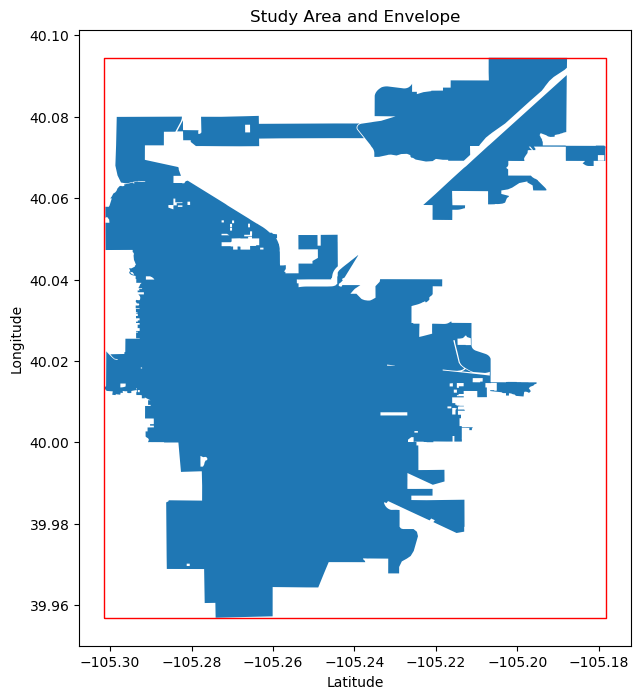

In [16]:
# Plot perimeter and envelope
fig, ax = plt.subplots(figsize=(12, 8))

limits_gdf.plot(ax=ax)
envelope_gdf.plot(facecolor='none', edgecolor='red', ax=ax)
ax.set(title='Study Area and Envelope', xlabel="Latitude", ylabel="Longitude")

### EarthExplorer M2M Download
The following cell sets up two classes that are used to connect to the EarthExplorer M2M API and download the desired data.

In [36]:
# Download ECOSTRESS LST data using M2M API
class BBox:
    """
    A class for a bounding box based on the total bounds of a raster image

    Parameters
    ----------
    total_bounds : the total bounds property of a GeoDataFrame

    Returns
    -------
    spatial_filter : dict-like BBox object containing filterType,
    lowerLeft coordinates, and upperRight coordinates
    """

    def __init__(self, total_bounds):
        self.llx, self.lly, self.urx, self.ury = total_bounds

    @property
    def spatial_filter(self):
        return {
            'filterType': "mbr",
            'lowerLeft': {'latitude': self.lly, 'longitude': self.llx},
            'upperRight': {'latitude': self.ury, 'longitude': self.urx}}


class EarthExplorerDownloader:
    """
    A class to contain the download information and instructions for
    downloads from the EarthExplorer M2M API.

    Parameters
    ----------
    dataset : name (str) of the desired USGS dataset
    label : str used for dir and path names
    bbox : BBox object used for selecting scenes
    start, end : start and end dates to filter for

    Returns
    -------
    Upon initialising, carries out login and returns confirmation or error

    submit_download_request method returns dataset alias for download

    download method returns downloaded filenames and saves files
    to specified path
    """

    base_url = "https://m2m.cr.usgs.gov/api/api/json/stable/{endpoint}"
    # product_filter = {
    #     'productName': 'HDF5'}
    dld_file_tmpl = '{display_id}'

    def __init__(self, dataset, label, bbox, start, end, productName):
        self.api_key = None
        self.login()

        self.dataset, self.label = dataset, label
        self.bbox, self.start, self.end = bbox, start, end

        self.temporal_filter = {'start': start, 'end': end}
        self.acquisition_filter = self.temporal_filter

        self.path_tmpl = os.path.join(self.label, self.dld_file_tmpl)
        if not os.path.exists(label):
            os.makedirs(label)

        self._dataset_alias = None
        self.product_filter = {
            'productName': productName}

    def get_ee_login_info(self, info_type):
        # Generate and store key

        # Encrypt
        key_path = os.path.join(pathlib.Path.home(), '.ee_key')
        if not os.path.exists(key_path):
            print('Generating new key...')
            key = Fernet.generate_key()
            with open(key_path, 'wb') as key_file:
                key_file.write(key)

        with open(key_path, 'rb') as key_file:
            key = key_file.read()
        fernet = Fernet(key)

        # Collect and store login info
        info_path = os.path.join(
            pathlib.Path.home(),
            '.ee_{}'.format(info_type))

        if not os.path.exists(info_path):
            info = input('Enter {}: '.format(info_type))
            with open(info_path, 'wb') as info_file:
                info_file.write(fernet.encrypt(bytes(info, 'utf-8')))

        with open(info_path, 'rb') as info_file:
            if len(info_file.read().decode('utf-8')) == 0:
                info = input('Enter {}: '.format(info_type))
                with open(info_path, 'wb') as info_file:
                    info_file.write(fernet.encrypt(bytes(info, 'utf-8')))

        # Decrypt for use
        with open(info_path, 'rb') as info_file:
            info_str = fernet.decrypt(info_file.read()).decode("utf-8")

        return info_str

    def login(self):
        # Submit (or collect) login information and obtain API key
        if self.api_key is None:
            login_payload = {
                'username': self.get_ee_login_info('username'),
                'password': self.get_ee_login_info('password')}
            self.api_key = self.post("login", login_payload)
            print('Login Successful')

    @property
    def headers(self):
        if self.api_key is None:
            return None
        return {'X-Auth-Token': self.api_key}

    def logout(self):
        self.post("logout", None)
        print("Logged Out\n\n")

    def post(self, endpoint, data):
        # Send POST requests
        url = self.base_url.format(endpoint=endpoint)
        response = requests.post(url, json.dumps(data), headers=self.headers)

        # Raise any HTTP Errors
        response.raise_for_status()

        # Return data
        return response.json()['data']

    @property
    def dataset_alias(self):
        # Retrieve dataset alias based on inputs
        if self._dataset_alias is None:
            print("Searching datasets...")
            params = {
                'datasetName': self.dataset,
                'spatialFilter': self.bbox.spatial_filter,
                'temporalFilter': self.temporal_filter}
            datasets = self.post("dataset-search", params)

            # Get a single dataset alias
            if len(datasets) > 1:
                print(datasets)
                raise ValueError('Multiple datasets found - refine search.')
            self._dataset_alias = datasets[0]['datasetAlias']

            print('Using dataset alias: {}'.format(self._dataset_alias))
        return self._dataset_alias

    def find_scene_ids(self):
        # Retrieve scene IDs based on input filters
        params = {
            'datasetName': self.dataset_alias,
            'startingNumber': 1,

            'sceneFilter': {
                'spatialFilter': self.bbox.spatial_filter,
                'acquisitionFilter': self.acquisition_filter}}

        print("Searching scenes...")
        scenes = self.post("scene-search", params)
        print('Found {} scenes'.format(scenes['recordsReturned']))
        return scenes

    def find_available_product_info(self):
        scenes = self.find_scene_ids()
        params = {
            'datasetName': self.dataset_alias,
            'entityIds': [scene['entityId'] for scene in scenes['results']]}
        products = self.post("download-options", params)

        # Aggregate a list of available products
        product_info = []
        for product in products:
            # Make sure the product is available for this scene
            if product['available'] is True or product['proxied'] is True:
                product_info.append({
                    'entityId': product['entityId'],
                    'productId': product['id']})
        if not product_info:
            raise ValueError('No available products.')
        return product_info

    def submit_download_request(self):
        product_info = self.find_available_product_info()
        self.product_info = product_info

        # Did we find products?
        if product_info:
            # Request downloads
            params = {
                'downloads': product_info,
                'label': self.label}
            self.post("download-request", params)
            print('Downloads staging...')
        else:
            raise ValueError(
                'No products found with the specified boundaries.')

    def check_download_status(self):
        params = {'label': self.label}
        downloads = self.post("download-retrieve", params)
        return downloads

    def wait_for_available_downloads(self, timeout=None):
        keep_waiting = True
        while keep_waiting:
            downloads = self.check_download_status()
            n_queued = downloads['queueSize']
            keep_waiting = n_queued > 0
            if keep_waiting:
                print("\n", n_queued,
                      "downloads queued but not yet available. "
                      "Waiting for 30 seconds.\n")
                time.sleep(30)

            if timeout is not None:
                timeout -= 30
                if timeout < 0:
                    break

        return downloads

    def download(self, wait=True, timeout=None, override=True):
        # Check download status
        if wait:
            downloads = self.wait_for_available_downloads(timeout=timeout)
        else:
            downloads = self.check_download_status()

        self.downloads = downloads

        available_or_proxied = (
            downloads['available']
            + [dld for dld in downloads['requested']
               if dld['statusCode'] == 'P'])
        if not available_or_proxied:
            raise ValueError('No available downloads.')

        # Download available downloads
        for download in available_or_proxied:
            # Filter out products
            if self.product_filter is not None:
                match = [download[k] == v for k,
                         v in self.product_filter.items()]
                if not all(match):
                    continue

            # Download and save compressed file
            dld_path = self.path_tmpl.format(display_id=download['displayId'])
            # Cache downloads
            if override or not os.path.exists(dld_path):
                print('Saving download: {}'.format(download['displayId']))
                with open(dld_path, 'wb') as dld_file:
                    response = requests.get(download['url'])
                    dld_file.write(response.content)

In [ ]:
# Download ECOSTRESS LST and Georeferencing Data
bbox = BBox(limits_gdf.total_bounds)
ee_dir = "eco_lst_test"
start_date = "2021-01-01"
end_date = "2021-01-04"

eco_downloader = EarthExplorerDownloader(
    dataset="ECO2LSTE",
    label=ee_dir,
    bbox=bbox,
    start=start_date,
    end=end_date,
    productName="HDF5")

geo_downloader = EarthExplorerDownloader(
    dataset="ECO1BGEO",
    label=ee_dir,
    bbox=bbox,
    start="2021-01-01",
    end="2021-01-04",
    productName="HDF5")

In [ ]:
# Download LST data with download request
eco_downloader.submit_download_request()
eco_downloader.download()

In [ ]:
# Download Georeferencing data with download request
geo_downloader.submit_download_request()
geo_downloader.download()

## Raw data processing
The ECOSTRESS data is downloaded as individual .h5 files for each scene. While this means they don't need any kind of uncompressing, they have to be processed before being a useable GeoDataFrame.

The following code is based off of the [ECOSTRESS Swath To Grid Conversion Script](https://git.earthdata.nasa.gov/projects/LPDUR/repos/ecostress_swath2grid/browse) provided by NASA's LP DAAC. The original script is meant to be called through the command line, but different functions were copied and adapted below to run inline in this product and convert .h5 files into GeoTIFFs.

Note: the current EE download has bugs! I have pointed the following code to a test sample of data to run the remaining cells by changing the path in ee_dir. LST and GEO data can be [downloaded here](https://e4ftl01.cr.usgs.gov/ECOSTRESS/).

In [ ]:
# Create lists of ECOSTRESS HDF-EOS5 files (geo, data) in the directory

# Using sample data in different folder to test data
# processing despite download bugs
ee_dir = "eco_direct_download"

geoList = [os.path.join(ee_dir, f) for f in os.listdir(
    ee_dir) if f.startswith('ECO') and f.endswith('.h5') and 'GEO' in f]
ecoList = [os.path.join(ee_dir, f) for f in os.listdir(
    ee_dir) if f.startswith('ECO') and f.endswith('.h5')]

ecoList

In [52]:
crsIN = 'GEO'  # Options include 'UTM' or 'GEO'

# Create dir for geoTIFF outputs
outDir = 'out_geotiff'
if not os.path.exists(working_dir):
    os.makedirs(working_dir)


def utmLookup(lat, lon):
    '''
    Determine which UTM zone to use
    '''

    utm = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm) == 1:
        utm = '0' + utm
    if lat >= 0:
        epsg_code = '326' + utm
    else:
        epsg_code = '327' + utm
    return epsg_code

In [ ]:
for i, e in enumerate(ecoList):
    '''
    Batch process all files in the input directory to convert swath to grid
    '''

    i += 1
    print('Processing: {} ({} of {})'.format(e, str(i), str(len(ecoList))))
    f = h5py.File(e, "r")  # Read in ECOSTRESS HDF5-EOS data file
    ecoName = e.split('.h5')[0]  # Keep original filename
    eco_objs = []
    f.visit(eco_objs.append)  # Retrieve list of datasets

    # Search for relevant SDS inside data file
    ecoSDS = [str(o) for o in eco_objs if isinstance(f[o], h5py.Dataset)]

    # Import geolocation File
    # Match GEO filename--updated to exclude build ID
    geo = [g for g in geoList if e[-37:-10] in g]
    if len(geo) != 0 or 'L1B_MAP' in e:  # Proceed if GEO/MAP file
        if 'L1B_MAP' in e:
            g = f  # Map file contains lat/lon
        else:
            g = h5py.File(geo[0], "r")  # Read in GEO file
        geo_objs = []
        g.visit(geo_objs.append)

        # Search for relevant SDS inside data file
        latSD = [str(o) for o in geo_objs if isinstance(
            g[o], h5py.Dataset) and '/latitude' in o]
        lonSD = [str(o) for o in geo_objs if isinstance(
            g[o], h5py.Dataset) and '/longitude' in o]
        lat = g[latSD[0]][()].astype(float)  # Open Lat array
        lon = g[lonSD[0]][()].astype(float)  # Open Lon array
        dims = lat.shape
        # Omit NA layers/objs
        ecoSDS = [s for s in ecoSDS if f[s].shape == dims]
        if ecoSDS == []:
            print('No matching SDS layers found for {}'.format(e))
            continue

        # Swath to georeferenced arrays
        swathDef = geom.SwathDefinition(lons=lon, lats=lat)
        midLat, midLon = np.mean(lat), np.mean(lon)

        if crsIN == 'UTM':
            epsg = utmLookup(midLat, midLon)

            epsgConvert = pyproj.Proj("+init=EPSG:{}".format(epsg))
            proj, pName = 'utm', 'Universal Transverse Mercator'
            projDict = {
                'proj': proj,
                'zone': epsg[-2:],
                'ellps': 'WGS84',
                'datum': 'WGS84',
                'units': 'm'}
            if epsg[2] == '7':
                projDict['south'] = 'True'  # Add for s. hemisphere UTM zones
            llLon, llLat = epsgConvert(np.min(lon), np.min(lat), inverse=False)
            urLon, urLat = epsgConvert(np.max(lon), np.max(lat), inverse=False)
            areaExtent = (llLon, llLat, urLon, urLat)
            ps = 70  # 70 is pixel size (meters)

        if crsIN == 'GEO':
            # Use info from aeqd bbox to calculate output cols/rows/pixel size
            epsgConvert = pyproj.Proj(
                "+proj=aeqd +lat_0={} +lon_0={}".format(midLat, midLon))
            llLon, llLat = epsgConvert(np.min(lon), np.min(lat), inverse=False)
            urLon, urLat = epsgConvert(np.max(lon), np.max(lat), inverse=False)
            areaExtent = (llLon, llLat, urLon, urLat)
            # 70 m pixel size
            cols = int(round((areaExtent[2] - areaExtent[0])/70))
            rows = int(round((areaExtent[3] - areaExtent[1])/70))

            '''Use no. rows and columns generated above from the
            aeqd projection to set a representative number of
            rows and columns, which will then be translated
            to degrees below, then take the smaller of the
            two pixel dims to determine output size'''

            epsg, proj, pName = '4326', 'longlat', 'Geographic'
            llLon, llLat, urLon, urLat = np.min(
                lon), np.min(lat), np.max(lon), np.max(lat)
            areaExtent = (llLon, llLat, urLon, urLat)
            projDict = pyproj.CRS("epsg:4326")
            areaDef = geom.AreaDefinition(
                epsg, pName, proj, projDict, cols, rows, areaExtent)
            # Square pixels
            ps = np.min([areaDef.pixel_size_x, areaDef.pixel_size_y])

        # Calculate the output cols
        cols = int(round((areaExtent[2] - areaExtent[0])/ps))
        # Calculate the output rows
        rows = int(round((areaExtent[3] - areaExtent[1])/ps))
        areaDef = geom.AreaDefinition(
            epsg, pName, proj, projDict, cols, rows, areaExtent)
        index, outdex, indexArr, distArr = kdt.get_neighbour_info(
            swathDef, areaDef, 210, neighbours=1)
    else:
        print('ECO1BGEO File not found for {}'.format(e))
        continue

    # Loop through SDS convert swath2grid and apply georeferencing
    for s in ecoSDS:
        ecoSD = f[s][()]  # Create array and read dimensions

        # Scale factor and add offset attribute names
        # updated in build 6, accounted for below:
        # '_Scale' or 'scale_factor'
        scaleName = [a for a in f[s].attrs if 'scale' in a.lower()]
        addoffName = [a for a in f[s].attrs if 'offset' in a.lower()]

        # Read SDS Attributes if available
        try:
            fv = int(f[s].attrs['_FillValue'])
        except KeyError:
            fv = None
        except ValueError:
            if f[s].attrs['_FillValue'] == b'n/a':
                fv = None
            elif type(f[s].attrs['_FillValue'][0]) == np.float32:
                fv = np.nan
            else:
                fv = f[s].attrs['_FillValue'][0]
        try:
            sf = f[s].attrs[scaleName[0]][0]
        except:
            sf = 1
        try:
            add_off = f[s].attrs[addoffName[0]][0]
        except:
            add_off = 0

        if 'ALEXI_USDA' in e:  # USDA Contains proj info in metadata
            if 'ET' in e:
                metaName = 'L3_ET_ALEXI Metadata'
            else:
                metaName = 'L4_ESI_ALEXI Metadata'
            gt = f[f"{metaName}/Geotransform"][()]
            proj = f['{}/OGC_Well_Known_Text'.format(
                metaName)][()].decode('UTF-8')
            sdGEO = ecoSD
        else:
            try:
                # Perform kdtree resampling (swath 2 grid conversion)
                sdGEO = kdt.get_sample_from_neighbour_info(
                    'nn', areaDef.shape, ecoSD, index,
                    outdex, indexArr, fill_value=fv)
                ps = np.min([areaDef.pixel_size_x, areaDef.pixel_size_y])
                gt = [areaDef.area_extent[0], ps, 0,
                      areaDef.area_extent[3], 0, -ps]
            except ValueError:
                continue

        # Apply Scale Factor and Add Offset
        sdGEO = sdGEO * sf + add_off

        # Set fill value
        if fv is not None:
            sdGEO[sdGEO == fv * sf + add_off] = fv

        # Export geotiffs
        # For USDA, export to UTM, then convert to GEO
        if 'ALEXI_USDA' in e and crsIN == 'GEO':
            tempName = '{}{}_{}_{}.tif'.format(
                outDir, ecoName, s.rsplit('/')[-1], 'TEMP')
            outName = tempName
        else:
            outName = '{}{}_{}_{}.tif'.format(
                outDir, ecoName, s.rsplit('/')[-1], crsIN)

        # Get driver, specify dimensions, define and set output geotransform
        height, width = sdGEO.shape  # Define geotiff dimensions
        driv = gdal.GetDriverByName('GTiff')
        dataType = gdal_array.NumericTypeCodeToGDALTypeCode(sdGEO.dtype)
        d = driv.Create(outName, width, height, 1, dataType)
        d.SetGeoTransform(gt)

        # Create and set output projection, write output array data
        if 'ALEXI_USDA' in e:
            d.SetProjection(proj)
        else:
            # Define target SRS
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(int(epsg))
            d.SetProjection(srs.ExportToWkt())
        band = d.GetRasterBand(1)
        band.WriteArray(sdGEO)

        # Define fill value if it exists, if not, set to mask fill value
        if fv is not None and fv != 'NaN':
            band.SetNoDataValue(fv)
        else:
            try:
                band.SetNoDataValue(int(sdGEO.fill_value))
            except AttributeError:
                pass
            except TypeError:
                pass

        band.FlushCache()

The remaining steps in this first product would be to clip and mask the data (with the ECO2CLD product for cloud masking) and review the data with different plots.

In [ ]:
# Clip and mask data

In [ ]:
# Review data